In [1]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
linestyle = ['-', '-', '-', '-', '-']
fig_width, fig_height = 8, 6

fig_names = [
    "Fig. 1: Result of Pre-Experiment",
]

file_path = "experimental_data.xlsx"

In [2]:
import matplotlib.font_manager as font_manager

# List all fonts available in the Matplotlib font manager
font_list = font_manager.findSystemFonts()
names = []

for font in font_list:
    try:
        prop = font_manager.FontProperties(fname=font)
        name = prop.get_name()
        if name not in names:  # This helps in avoiding duplicates
            names.append(name)
        if "DM Sans" in name:  # Check if DM Sans is in the list
            print(f"DM Sans font found at: {font}")
    except Exception as e:
        print(f"Failed to load font: {font}, due to error: {e}")

# Print the sorted list of font names
names.sort()
print("Available fonts for matplotlib:")
for name in names:
    print(name)


DM Sans font found at: /Users/haoyungweng/Library/Fonts/DMSans-VariableFont_opsz,wght.ttf
Failed to load font: /System/Library/Fonts/Apple Color Emoji.ttc, due to error: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
DM Sans font found at: /Users/haoyungweng/Library/Fonts/DMSans-Italic-VariableFont_opsz,wght.ttf
Failed to load font: /System/Library/Fonts/Supplemental/NISC18030.ttf, due to error: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
Available fonts for matplotlib:
.Aqua Kana
.Keyboard
.LastResort
.New York
.SF Arabic
.SF Arabic Rounded
.SF Armenian
.SF Armenian Rounded
.SF Camera
.SF Compact
.SF Compact Rounded
.SF Georgian
.SF Georgian Rounded
.SF Hebrew
.SF Hebrew Rounded
.SF NS Mono
.SF NS Rounded
.SF Soft Numeric
.ThonburiUI
Academy Engraved LET
Al Bayan
Al Nile
Al Tarikh
American Typewriter
Andale Mono
Apple Braille
Apple Chancery
Apple LiGothic
Apple LiSung
Apple SD Gothic Neo
Apple Symbols
AppleGothic
AppleMyun

In [3]:
import matplotlib.pyplot as plt

print(plt.rcParams["font.sans-serif"][0])
print(plt.rcParams["font.monospace"][0])

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["DM Sans"]

DejaVu Sans
DejaVu Sans Mono


In [4]:
from typing import List, Tuple, Optional
import pandas as pd
import numpy as np

def calculate_color_with_alpha(color: str, alpha: float) -> str:
    """Modify a hex color string based on an alpha blending towards white."""
    r, g, b = (int(color[i:i+2], 16) for i in (1, 3, 5))
    new_color = (int(alpha * c + (1 - alpha) * 255) for c in (r, g, b))
    return '#{:02x}{:02x}{:02x}'.format(*new_color)

def read_excel_data(file_path: str, sheet_name: Optional[str] = None) -> List[List[str]]:
    """Read an Excel file into a list of lists, transposed, optionally specifying a sheet name."""
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)
    transposed_data = df.transpose().values.tolist()
    return transposed_data

def preprocess_data(data: List[List[str]], label_row_index: int = 0, multiply: float = 1) -> Tuple[List[List[float]], List[str]]:
    """Convert transposed data rows into separate lists of measurements and labels.
    Assumes the first row (after transposition) is an identifier and thus skips it for measurements."""
    labels = [row[label_row_index] for row in data]  # Extracting labels
    measurements = [[float(value) * multiply for value in row[label_row_index+1:]] for row in data]  # Extracting data
    return measurements[1:], labels[1:]  # Skipping the first set assuming it's an identifier

def calculate_stats(measurements: List[List[float]]) -> Tuple[List[float], List[float]]:
    """Calculate mean and standard deviation of lists of measurements."""
    means = [np.mean(measurement_list) for measurement_list in measurements]
    std_devs = [np.std(measurement_list) for measurement_list in measurements]
    return means, std_devs

In [98]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.stats import t, ttest_ind_from_stats
import mc3

# Helper function to perform t-test using summary statistics
def ttest_ind_from_stats(mean1, std1, nobs1, mean2, std2, nobs2):
  se1 = std1 / np.sqrt(nobs1)
  se2 = std2 / np.sqrt(nobs2)
  sed = np.sqrt(se1**2 + se2**2)
  t_stat = (mean1 - mean2) / sed
  df = min(nobs1 - 1, nobs2 - 1)
  p_value = 2 * (1 - t.cdf(np.abs(t_stat), df))
  return t_stat, p_value
  
def finalize_plot(fig_num):
  # plt.title(fig_names[fig_num - 1], pad=13, fontsize='x-large')
  plt.tight_layout(pad=2)
  # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.savefig(f"fig{fig_num}.png")
  
def draw_pre_exp(sheet_name, fig_num):
  comparison_data = read_excel_data(file_path, sheet_name)
  print(comparison_data)
  labels, TBTs, EYs = [list[1:] for list in comparison_data]
  EYs = [EY*100 for EY in EYs]
  print(labels, TBTs, EYs)

  # Create the line graph
  fig1, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)
  
  gradient_colors = [colors[0], calculate_color_with_alpha(colors[1], 0.5), colors[1]]

  for i in range(len(labels)):
      ax.scatter(TBTs[i], EYs[i], marker='o', s=25, alpha=1, label=labels[i], color=gradient_colors[i], zorder=3)

  ax.set_xlabel('Total Brew Time (TBT) (s)', verticalalignment='center_baseline', labelpad=13)
  ax.set_ylabel('Extraction Yield (EY) (%)', verticalalignment='center_baseline', labelpad=13)
  ax.set_xlim(150, 300)
  ax.set_xticks([180, 210, 240, 270])
  ax.set_ylim(20, 22)
  ax.set_yticks([20.5, 21, 21.5])
  ax.xaxis.grid(zorder=0)
  ax.yaxis.grid(zorder=0)
  ax.tick_params(bottom=False)
  
  dots = [mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                        markersize=5, label=label) for color, label in zip(gradient_colors, labels)]
  dots.insert(1, mlines.Line2D([], [], color='none', marker='none', linestyle='none'))
  ax.legend(handles=dots, loc='upper right',
              frameon=False, ncol=2, handletextpad=0.5, handlelength=0.5, columnspacing=1)

  finalize_plot(fig_num)
  
def draw_main_exp(sheet_name, fig_num):
  comparison_data = read_excel_data(file_path, sheet_name)
  print(comparison_data)
  tmp_labels, TBTs, EYs = [list[1:] for list in comparison_data]
  EYs = [EY*100 for EY in EYs]
  
  labels = []
  for i in range(len(tmp_labels)):
    if not pd.isna(tmp_labels[i]):
      labels.append(tmp_labels[i])
      
  print(labels, TBTs, EYs)

  # Create the line graph
  fig1, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)

  gradient_colors = []
  for color in colors[:2]:
    gradient_colors.append(calculate_color_with_alpha(color, 1/3))
    gradient_colors.append(calculate_color_with_alpha(color, 2/3))
    gradient_colors.append(calculate_color_with_alpha(color, 1))
  
  for i in range(len(TBTs)):
      ax.scatter(TBTs[i], EYs[i], marker='o', s=25, alpha=1, label=labels[i//2], color=gradient_colors[i//2], zorder=3)

  ax.set_xlabel('Total Brew Time (TBT) (s)', verticalalignment='center_baseline', labelpad=13)
  ax.set_ylabel('Extraction Yield (EY) (%)', verticalalignment='center_baseline', labelpad=13)
  ax.set_xlim(180, 420)
  ax.set_xticks([240, 300, 360])
  ax.set_ylim(20.5, 23.5)
  ax.set_yticks([21, 22, 23])
  ax.xaxis.grid(zorder=0)
  ax.yaxis.grid(zorder=0)
  ax.tick_params(bottom=False)
  
  dots = [mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                        markersize=5, label=label) for color, label in zip(gradient_colors, labels)]
  # order = [0, 3, 1, 4, 2, 5]
  # dots = [dots[i] for i in order]
  ax.legend(handles=dots, loc='upper right',
              frameon=False, ncol=2, handletextpad=0.5, handlelength=0.5, columnspacing=1)
  
  finalize_plot(fig_num)
  
def draw_main_exp_line(sheet_name, fig_num):
  comparison_data = read_excel_data(file_path, sheet_name)
  print(comparison_data)
  tmp_labels, TBTs, EYs = [list[1:] for list in comparison_data]
  EYs = [EY*100 for EY in EYs]
  
  labels = ['WWDT', 'CTL']
  print(labels, TBTs, EYs)
  
  # Create the line graph
  fig1, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)
  
  gradient_colors = []
  for color in colors[:2]:
    gradient_colors.append(calculate_color_with_alpha(color, 1/3))
    gradient_colors.append(calculate_color_with_alpha(color, 2/3))
    gradient_colors.append(calculate_color_with_alpha(color, 1))

  for i in range(len(TBTs)):
    ax.scatter(TBTs[i], EYs[i], marker='o', s=25, alpha=1, label=labels[i//6], color=colors[i//6], zorder=3)

  ax.set_xlabel('Total Brew Time (TBT) (s)', verticalalignment='center_baseline', labelpad=13)
  ax.set_ylabel('Extraction Yield (EY) (%)', verticalalignment='center_baseline', labelpad=13)
  ax.set_xlim(180, 420)
  ax.set_xticks([240, 300, 360])
  ax.set_ylim(20.5, 23.5)
  ax.set_yticks([21, 22, 23])
  ax.xaxis.grid(zorder=0)
  ax.yaxis.grid(zorder=0)
  ax.tick_params(bottom=False)
  
  dots = [mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                        markersize=5, label=label) for color, label in zip(colors, labels)]
  ax.legend(handles=dots, loc='upper right',
              frameon=False, ncol=2, handletextpad=0.5, handlelength=0.5, columnspacing=1)
    
  # Define the modified exponential model
  def exponential_model(t, k, EY_max):
    return EY_max * (1 - np.exp(-k * t))

  # Prepare data for WWDT and CTL
  wwdt_data = {'TBT': np.array(TBTs[:6]), 'EY': np.array(EYs[:6])}
  ctl_data = {'TBT': np.array(TBTs[6:]), 'EY': np.array(EYs[6:])}
  all_data = {'TBT': np.array(TBTs), 'EY': np.array(EYs)}

  # Fit the exponential model to WWDT data
  params_wwdt_exp, pcov_wwdt_exp = curve_fit(exponential_model, wwdt_data['TBT'], wwdt_data['EY'], p0=[0.005, 25], bounds=(0, [np.inf, np.inf]))

  # Fit the exponential model to CTL data
  params_ctl_exp, pcov_ctl_exp = curve_fit(exponential_model, ctl_data['TBT'], ctl_data['EY'], p0=[0.005, 25], bounds=(0, [np.inf, np.inf]))
  
  params_all_exp, pcov_all_exp = curve_fit(exponential_model, all_data['TBT'], all_data['EY'], p0=[0.005, 25], bounds=(0, [np.inf, np.inf]))

  # Plot the fitted exponential curves
  for tech, params, color in zip(['WWDT Exp', 'CTL Exp'], [params_wwdt_exp, params_ctl_exp], colors[:2]):
      TBT_range = np.linspace(100, 500, 100)
      EY_pred = exponential_model(TBT_range, *params)
      ax.plot(TBT_range, EY_pred, color=color, linestyle='-', label=f'{tech} Fit: k={params[0]:.3f}, EY_max={params[1]:.1f}')

  # Compare the parameters for exponential model
  k_wwdt, EY_max_wwdt = params_wwdt_exp
  k_ctl, EY_max_ctl = params_ctl_exp
  k_all, EY_max_all = params_all_exp

  print(f'Parameter k for WWDT (Exp): {k_wwdt}')
  print(f'Parameter EY_max for WWDT (Exp): {EY_max_wwdt}')
  print(f'Parameter k for CTL (Exp): {k_ctl}')
  print(f'Parameter EY_max for CTL (Exp): {EY_max_ctl}')
  print(f'Parameter k for ALL (Exp): {k_all}')
  print(f'Parameter EY_max for ALL (Exp): {EY_max_all}')
  
  # Calculate standard errors of the fitted parameters
  perr_wwdt_exp = np.sqrt(np.diag(pcov_wwdt_exp))
  perr_ctl_exp = np.sqrt(np.diag(pcov_ctl_exp))

  # Perform t-tests for the parameters
  t_stat_k, p_value_k = ttest_ind_from_stats(mean1=k_wwdt, std1=perr_wwdt_exp[0], nobs1=len(wwdt_data['TBT']),
                                              mean2=k_ctl, std2=perr_ctl_exp[0], nobs2=len(ctl_data['TBT']))

  t_stat_EY_max, p_value_EY_max = ttest_ind_from_stats(mean1=EY_max_wwdt, std1=perr_wwdt_exp[1], nobs1=len(wwdt_data['TBT']),
                                                        mean2=EY_max_ctl, std2=perr_ctl_exp[1], nobs2=len(ctl_data['TBT']))

  print(f'T-test result for k: t-statistic = {t_stat_k:.3f}, p-value = {p_value_k}')
  print(f'T-test result for EY_max: t-statistic = {t_stat_EY_max:.3f}, p-value = {p_value_EY_max}')
    
  finalize_plot(fig_num)
  
def draw_main_exp_line_MCMC(sheet_name, fig_num, wwdt_estimates, ctl_estimates):
  comparison_data = read_excel_data(file_path, sheet_name)
  print(comparison_data)
  tmp_labels, TBTs, EYs = [list[1:] for list in comparison_data]
  EYs = [EY*100 for EY in EYs]
  
  labels = ['WWDT', 'CTL']
  print(labels, TBTs, EYs)
  
  # Create the line graph
  fig1, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=300)
  
  gradient_colors = []
  for color in colors[:2]:
    gradient_colors.append(calculate_color_with_alpha(color, 1/3))
    gradient_colors.append(calculate_color_with_alpha(color, 2/3))
    gradient_colors.append(calculate_color_with_alpha(color, 1))

  for i in range(len(TBTs)):
    ax.scatter(TBTs[i], EYs[i], marker='o', s=25, alpha=1, label=labels[i//6], color=colors[i//6], zorder=3)

  ax.set_xlabel('Total Brew Time (TBT) (s)', verticalalignment='center_baseline', labelpad=13)
  ax.set_ylabel('Extraction Yield (EY) (%)', verticalalignment='center_baseline', labelpad=13)
  ax.set_xlim(180, 420)
  ax.set_xticks([240, 300, 360])
  ax.set_ylim(20.5, 23.5)
  ax.set_yticks([21, 22, 23])
  ax.xaxis.grid(zorder=0)
  ax.yaxis.grid(zorder=0)
  ax.tick_params(bottom=False)
  
  dots = [mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                        markersize=5, label=label) for color, label in zip(colors, labels)]
  ax.legend(handles=dots, loc='upper right',
              frameon=False, ncol=2, handletextpad=0.5, handlelength=0.5, columnspacing=1)
  
  # Define the modified exponential model
  def exponential_model(t, k, EY_max):
    return EY_max * (1 - np.exp(-k * t))
  
  # Define TBT range
  TBT_range = np.linspace(100, 500, 100)
  # Loop through the estimates and colors
  for tech, params, color in zip(['WWDT Exp', 'CTL Exp'], [wwdt_estimates, ctl_estimates], colors[:2]):
      EY_pred_first = exponential_model(TBT_range, params['k'][0], params['EY_max'][0])
      EY_pred_second = exponential_model(TBT_range, params['k'][1], params['EY_max'][1])
      ax.plot(TBT_range, EY_pred_second, color=color, linestyle='-')
      EY_pred_third = exponential_model(TBT_range, params['k'][2], params['EY_max'][2])
      # Fill the area between the first and third lines
      ax.fill_between(TBT_range, EY_pred_first, EY_pred_third, color=color, alpha=0.3, edgecolor='none')
    
  finalize_plot(fig_num)

def draw_main_exp_line_MCMC_square(sheet_name, fig_num, wwdt_estimates, ctl_estimates):
  comparison_data = read_excel_data(file_path, sheet_name)
  print(comparison_data)
  tmp_labels, TBTs, EYs = [list[1:] for list in comparison_data]
  EYs = [EY*100 for EY in EYs]
  
  labels = ['WWDT', 'CTL']
  print(labels, TBTs, EYs)
  
  # Create the line graph
  fig1, ax = plt.subplots(figsize=(6, 6), dpi=300)
  
  gradient_colors = []
  for color in colors[:2]:
    gradient_colors.append(calculate_color_with_alpha(color, 1/3))
    gradient_colors.append(calculate_color_with_alpha(color, 2/3))
    gradient_colors.append(calculate_color_with_alpha(color, 1))

  for i in range(len(TBTs)):
    ax.scatter(TBTs[i], EYs[i], marker='o', s=16, alpha=1, label=labels[i//6], color=colors[i//6], zorder=3)

  ax.set_xlabel('Total Brew Time (TBT) (s)', verticalalignment='center_baseline', labelpad=13)
  ax.set_ylabel('Extraction Yield (EY) (%)', verticalalignment='center_baseline', labelpad=13)
  ax.set_xlim(180, 420)
  ax.set_xticks([240, 300, 360])
  ax.set_ylim(20, 24)
  ax.set_yticks([21, 22, 23])
  ax.xaxis.grid(zorder=0)
  ax.yaxis.grid(zorder=0)
  ax.tick_params(bottom=False)
  
  dots = [mlines.Line2D([], [], color=color, marker='o', linestyle='None',
                        markersize=4, label=label) for color, label in zip(colors, labels)]
  ax.legend(handles=dots, loc='upper right',
              frameon=False, ncol=2, handletextpad=0.4, handlelength=0.4, columnspacing=0.7)
  
  # Define the modified exponential model
  def exponential_model(t, k, EY_max):
    return EY_max * (1 - np.exp(-k * t))
  
  # Define TBT range
  TBT_range = np.linspace(100, 500, 100)
  # Loop through the estimates and colors
  for tech, params, color in zip(['WWDT Exp', 'CTL Exp'], [wwdt_estimates, ctl_estimates], colors[:2]):
      EY_pred_first = exponential_model(TBT_range, params['k'][0], params['EY_max'][0])
      EY_pred_second = exponential_model(TBT_range, params['k'][1], params['EY_max'][1])
      ax.plot(TBT_range, EY_pred_second, color=color, linestyle='-')
      EY_pred_third = exponential_model(TBT_range, params['k'][2], params['EY_max'][2])
      # Fill the area between the first and third lines
      ax.fill_between(TBT_range, EY_pred_first, EY_pred_third, color=color, alpha=0.3, edgecolor='none')
    
  plt.tight_layout(pad=1.5)
  # plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.savefig(f"fig{fig_num}.png")
  
def MCMC(sheet_name, fig_num):
    comparison_data = read_excel_data(file_path, sheet_name)
    _, TBTs, EYs = [list[1:] for list in comparison_data]
    EYs = [EY * 100 for EY in EYs]

    labels = ['WWDT', 'CTL']

    def exponential_model(t, k, EY_max):
      return EY_max * (1 - np.exp(-k * t))

    wwdt_data = {'TBT': np.array(TBTs[:6]), 'EY': np.array(EYs[:6])}
    ctl_data = {'TBT': np.array(TBTs[6:]), 'EY': np.array(EYs[6:])}

    def log_prior(theta):
        k, EY_max = theta
        if k > 0 and EY_max > 0:
            return 0.
        else:
            return -np.inf

    def log_likelihood(theta, t, ey):
        model_ey = exponential_model(t, *theta)
        sigma2 = 0.01  # Assumed error, you can adjust this based on your data
        return -0.5 * np.sum((ey - model_ey) ** 2 / sigma2 + np.log(sigma2))

    def log_posterior(theta, t, ey):
        lp = log_prior(theta)
        ll = log_likelihood(theta, t, ey)
        if np.isfinite(lp) and np.isfinite(ll):
            return lp + ll
        else:
            return -np.inf
          
    import emcee

    ndim = 2  # number of parameters in the model
    nwalkers = 50  # number of MCMC walkers
    nburn = 100  # "burn-in" period to let chains stabilize
    nthin = 15  # thin by about half the autocorrelation time
    nsteps = 2000  # number of MCMC steps to take

    # Initialize MCMC walkers
    initial_guesses = [0.01, 23]  # Initial guess for parameters
    starting_guesses = initial_guesses + 1e-4 * np.random.randn(nwalkers, ndim)

    # Function to run MCMC
    def run_mcmc(t, ey):
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[t, ey])
        sampler.run_mcmc(starting_guesses, nsteps, progress=True)
        return sampler

    # Run MCMC for WWDT data
    sampler_wwdt = run_mcmc(wwdt_data['TBT'], wwdt_data['EY'])
    flat_samples_wwdt = sampler_wwdt.get_chain(discard=nburn, thin=nthin, flat=True)

    # Run MCMC for CTL data
    sampler_ctl = run_mcmc(ctl_data['TBT'], ctl_data['EY'])
    flat_samples_ctl = sampler_ctl.get_chain(discard=nburn, thin=nthin, flat=True)

    import matplotlib.pyplot as plt
    import corner

    labels = ['k', 'EY_max']

    # # Plot corner plot for WWDT data
    # fig_wwdt = corner.corner(flat_samples_wwdt, labels=labels)
    # plt.show()

    # # Plot corner plot for CTL data
    # fig_ctl = corner.corner(flat_samples_ctl, labels=labels)
    # plt.show()

    # Calculate parameter estimates
    def parameter_estimates(flat_samples):
        # print(flat_samples)
        estimates = {}
        for i, label in enumerate(labels):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            estimates[label] = mcmc
            print(mcmc)
            q = np.diff(mcmc)
            print(f"{label} = {mcmc[1]:.3f}_{{-{q[0]:.3f}}}^{{{q[1]:.3f}}}")
        return estimates

    print("WWDT Parameter Estimates:")
    wwdt_estimates = parameter_estimates(flat_samples_wwdt)

    print("CTL Parameter Estimates:")
    ctl_estimates = parameter_estimates(flat_samples_ctl)
    
    return wwdt_estimates, ctl_estimates

[[nan, 'WWDT-fast', nan, 'WWDT-mid', nan, 'WWDT-slow', nan, 'CTL-fast', nan, 'CTL-mid', nan, 'CTL-slow', nan], ['TBT', 253, 249, 257, 267, 369, 337, 217, 219, 235, 229, 339, 309], ['EY', 0.217573, 0.21831, 0.220248, 0.219907, 0.228014, 0.225741, 0.213864, 0.213133, 0.214936, 0.21507, 0.227271, 0.22379]]
['WWDT', 'CTL'] [253, 249, 257, 267, 369, 337, 217, 219, 235, 229, 339, 309] [21.757299999999997, 21.831, 22.0248, 21.9907, 22.8014, 22.5741, 21.3864, 21.313299999999998, 21.493599999999997, 21.507, 22.7271, 22.378999999999998]


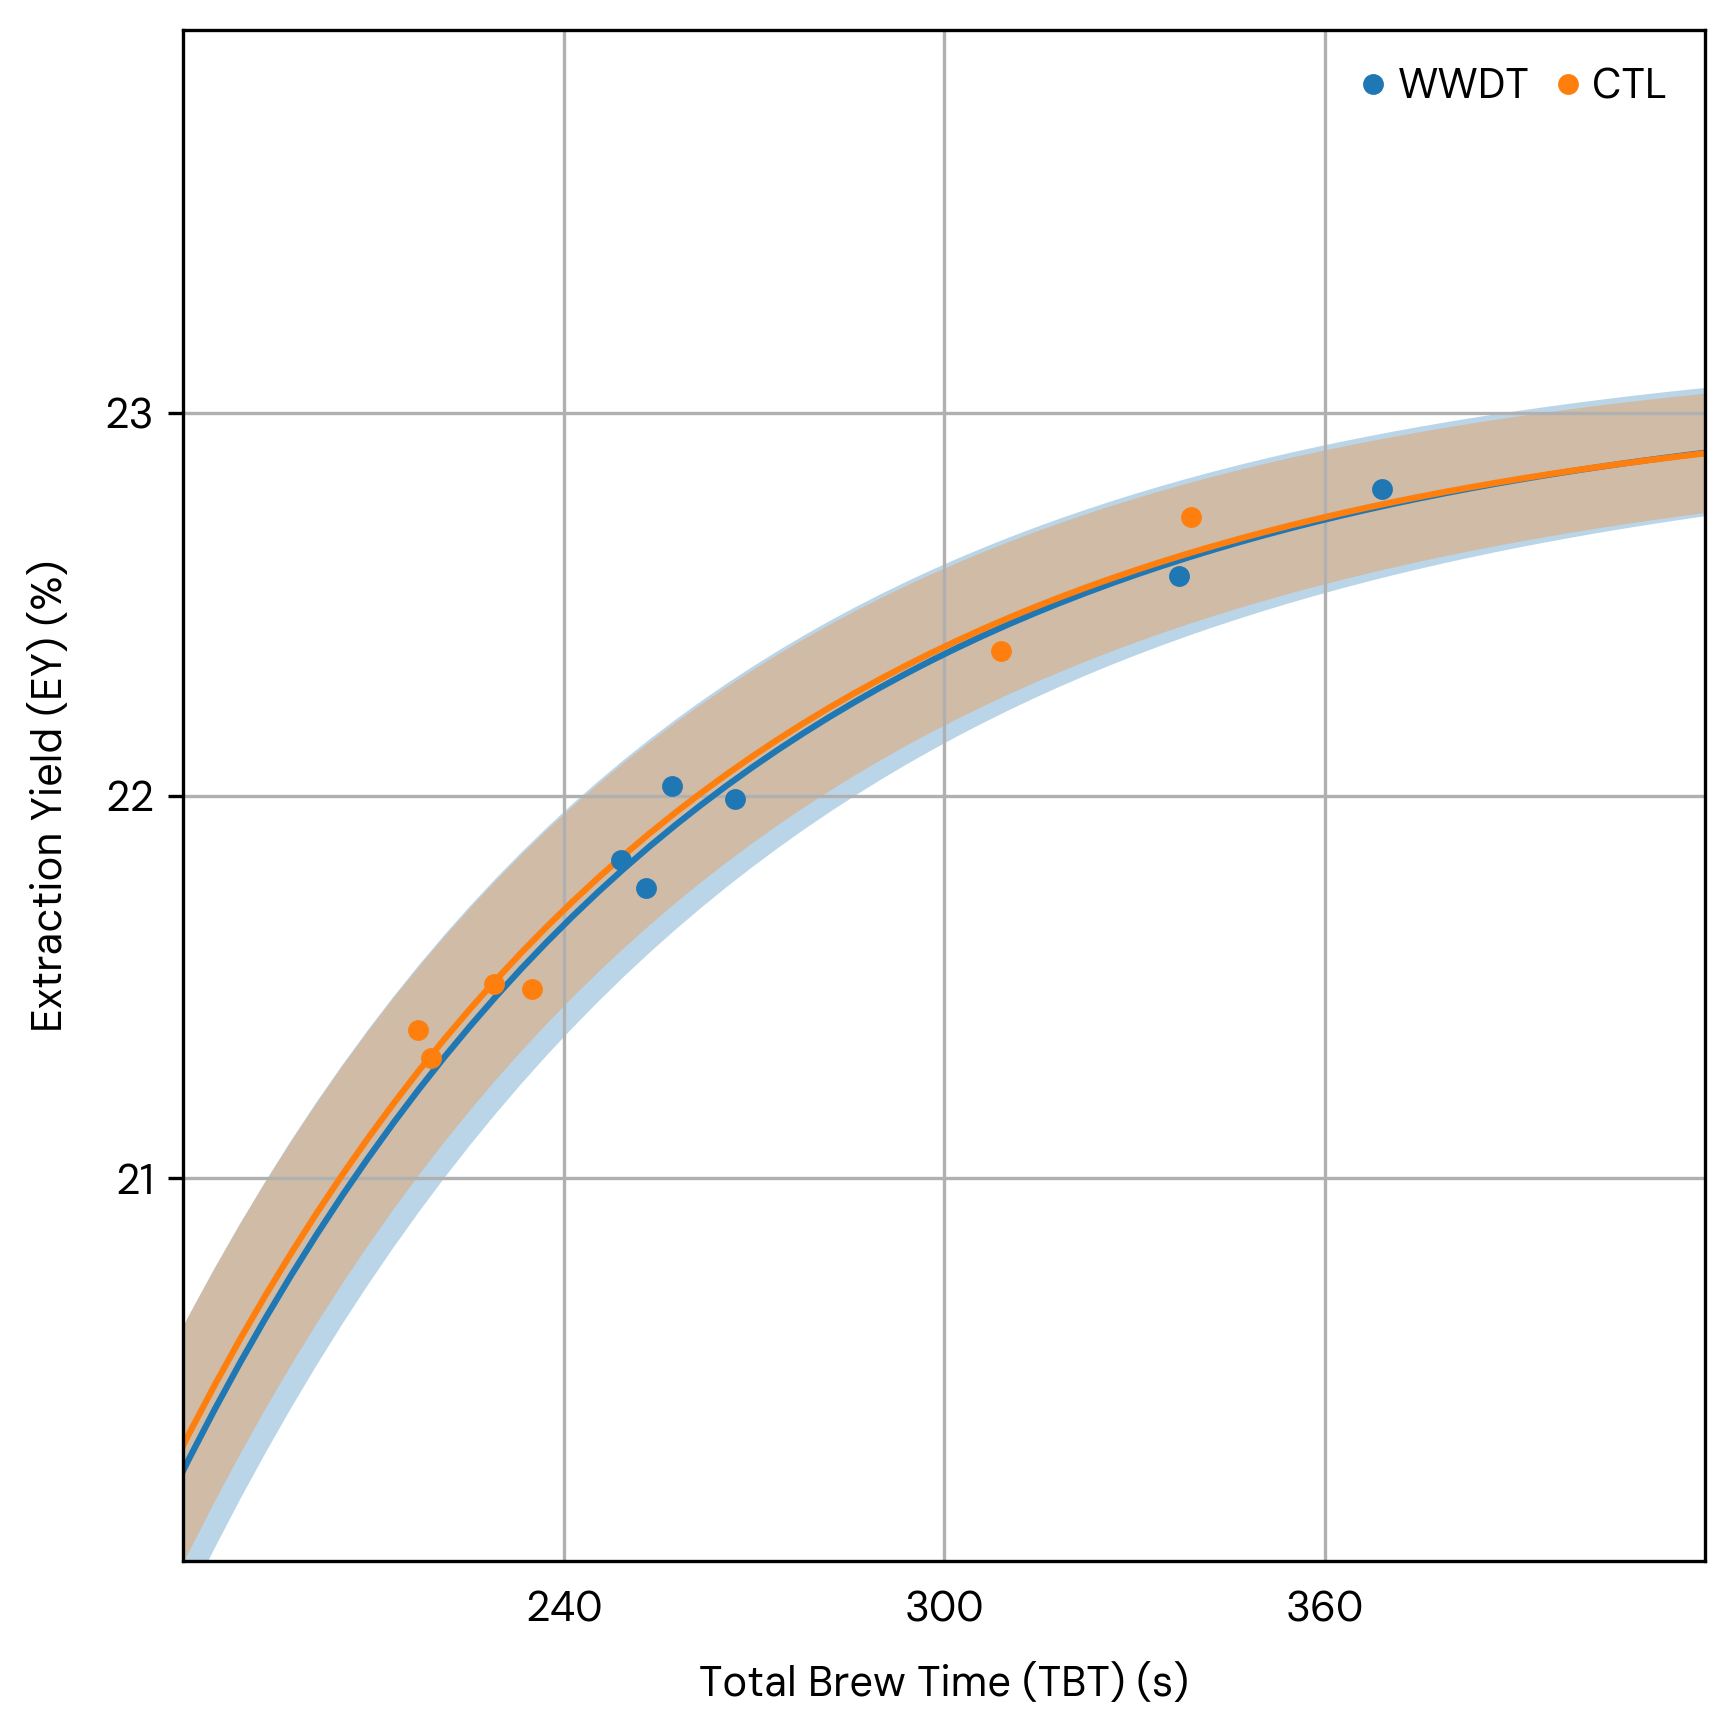

In [99]:
# draw_pre_exp('Pre', 1)
# draw_main_exp('Main', 2)
# draw_main_exp_line('Main', 3)
# wwdt_estimates, ctl_estimates = MCMC('Main', 3)
# print(wwdt_estimates, ctl_estimates)
# draw_main_exp_line_MCMC('Main', 4, wwdt_estimates, ctl_estimates)
draw_main_exp_line_MCMC_square('Main', 5, wwdt_estimates, ctl_estimates)

In [7]:
import matplotlib.font_manager as fm
available_fonts = set(f.name for f in fm.fontManager.ttflist)
print("DM Sans" in available_fonts)  # Should print True if the font is available

True


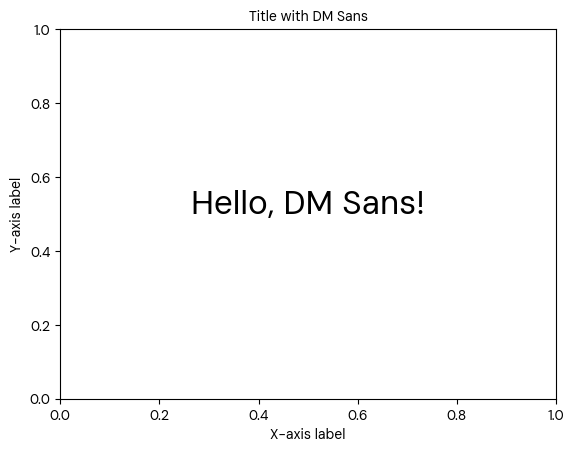

In [9]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Use the exact path to the DM Sans font file
font_path = "/Users/haoyungweng/Library/Fonts/DMSans-VariableFont_opsz,wght.ttf"
prop = font_manager.FontProperties(fname=font_path)

# Apply the font directly in a plot
plt.text(0.5, 0.5, "Hello, DM Sans!", fontproperties=prop, fontsize=24, ha='center')
plt.title("Title with DM Sans", fontproperties=prop)
plt.xlabel("X-axis label", fontproperties=prop)
plt.ylabel("Y-axis label", fontproperties=prop)
plt.show()
